<a href="https://colab.research.google.com/github/notakshitgoyal/neural_network_classification/blob/main/neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Make some Data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles
#make 1000 samples
n_samples = 1000
#create circles
X,y = make_circles(n_samples,noise = 0.03,random_state= 42)

In [3]:
print(f"First 5 samples of X:{X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [4]:
#make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                       })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


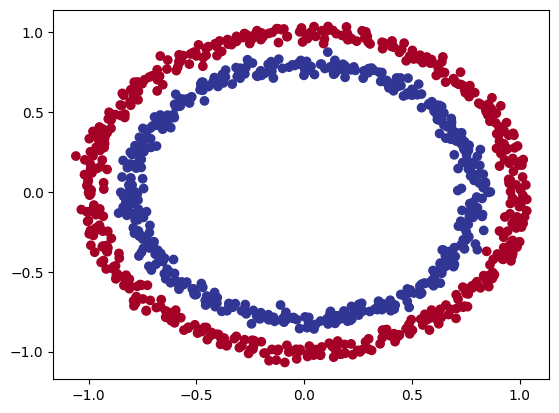

In [5]:
#visulaize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c = y,
            cmap=plt.cm.RdYlBu)

#check input and output shapes

In [6]:
X.shape,y.shape

((1000, 2), (1000,))

#turn data into tensors and create train and test splits

In [7]:
#turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
#split data into traing and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

## building a model
1. Device agonistic code
2. construct a model (nn.Module)
3.define loss and optimizer
4.training and test loop

In [9]:
import torch
from torch import nn
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#constructing a model
1. Subclasses nn.Module
2. create 2 nn.Linear() layers that are capable of handling the shape of handling the shapes of our model
3. forward pass
4. initiate a instance for our model

In [10]:
class Circle_v0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2,out_features= 5)
    self.layer_2 = nn.Linear(in_features = 5,out_features = 1)

  def forward(self,x):
    return self.layer2(self.layer1(x))


In [11]:
#instantiate an instance of our model
model_0 = Circle_v0().to(device)
model_0

Circle_v0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
#lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features= 2,out_features=5),
    nn.Linear(in_features= 5,out_features = 1)
).to(device)

In [13]:
#setup loss function and
import torch
import torch.optim as optim
import torch.nn as nn
loss_fn = nn.BCEWithLogitsLoss() #has sigmoid inbuilt
optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

In [14]:
#calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [15]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1798],
        [-0.0358],
        [-0.1613],
        [-0.2086],
        [-0.0121]], device='cuda:0', grad_fn=<SliceBackward0>)

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4552],
        [0.4910],
        [0.4598],
        [0.4480],
        [0.4970]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]

tensor([1., 0., 0., 0., 1.])

#training model

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#epochs
epochs = 100
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model_0.train()
  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  #optimize zero grad
  optimizer.zero_grad()
  #backpropagation
  loss.backward()
  #optimizer step
  optimizer.step()
  #testing
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #cal the loss
    test_loss= loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred = test_pred)
  #print out whats happening
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69454, Accuracy: 41.00% | Test loss: 0.69701, Test acc: 42.00%
Epoch: 10 | Loss: 0.69349, Accuracy: 48.62% | Test loss: 0.69650, Test acc: 45.50%
Epoch: 20 | Loss: 0.69314, Accuracy: 49.38% | Test loss: 0.69637, Test acc: 46.50%
Epoch: 30 | Loss: 0.69302, Accuracy: 50.50% | Test loss: 0.69630, Test acc: 47.00%
Epoch: 40 | Loss: 0.69296, Accuracy: 51.00% | Test loss: 0.69623, Test acc: 47.00%
Epoch: 50 | Loss: 0.69293, Accuracy: 51.12% | Test loss: 0.69616, Test acc: 47.50%
Epoch: 60 | Loss: 0.69291, Accuracy: 51.62% | Test loss: 0.69609, Test acc: 47.00%
Epoch: 70 | Loss: 0.69290, Accuracy: 51.38% | Test loss: 0.69603, Test acc: 47.00%
Epoch: 80 | Loss: 0.69289, Accuracy: 50.88% | Test loss: 0.69597, Test acc: 47.50%
Epoch: 90 | Loss: 0.69288, Accuracy: 51.12% | Test loss: 0.69592, Test acc: 46.50%


In [20]:
#visualize
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists,skipping download")
else:
  print("Downloading function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions,plot_decision_boundary

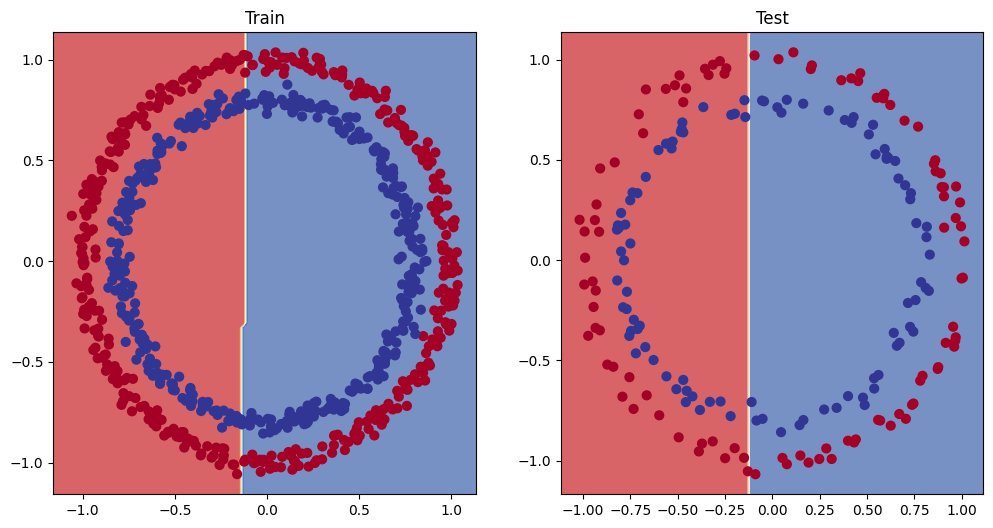

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#improving a model(from models perspective)
* Add more layers
* Add more hidden layers
* Fit for longer
* changing the activation functions
* change the learning rate
* change the loss functions


In [22]:
class circleV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2,out_features= 10)
    self.layer_2 = nn.Linear(in_features = 10,out_features = 10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = circleV1().to(device)
model_1

circleV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(),lr = 0.1)
epochs = 1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true= y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true= y_test,y_pred= test_pred)
    if epoch %100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69439, Accuracy: 49.88% | Test loss: 0.69092, Test acc: 55.00%
Epoch: 100 | Loss: 0.69293, Accuracy: 51.88% | Test loss: 0.69452, Test acc: 46.50%
Epoch: 200 | Loss: 0.69285, Accuracy: 52.00% | Test loss: 0.69561, Test acc: 44.50%
Epoch: 300 | Loss: 0.69285, Accuracy: 51.88% | Test loss: 0.69586, Test acc: 44.50%
Epoch: 400 | Loss: 0.69285, Accuracy: 51.75% | Test loss: 0.69592, Test acc: 44.50%
Epoch: 500 | Loss: 0.69285, Accuracy: 51.75% | Test loss: 0.69593, Test acc: 44.50%
Epoch: 600 | Loss: 0.69285, Accuracy: 51.75% | Test loss: 0.69593, Test acc: 44.50%
Epoch: 700 | Loss: 0.69285, Accuracy: 51.88% | Test loss: 0.69594, Test acc: 44.50%
Epoch: 800 | Loss: 0.69285, Accuracy: 51.88% | Test loss: 0.69594, Test acc: 44.50%
Epoch: 900 | Loss: 0.69285, Accuracy: 51.88% | Test loss: 0.69594, Test acc: 44.50%


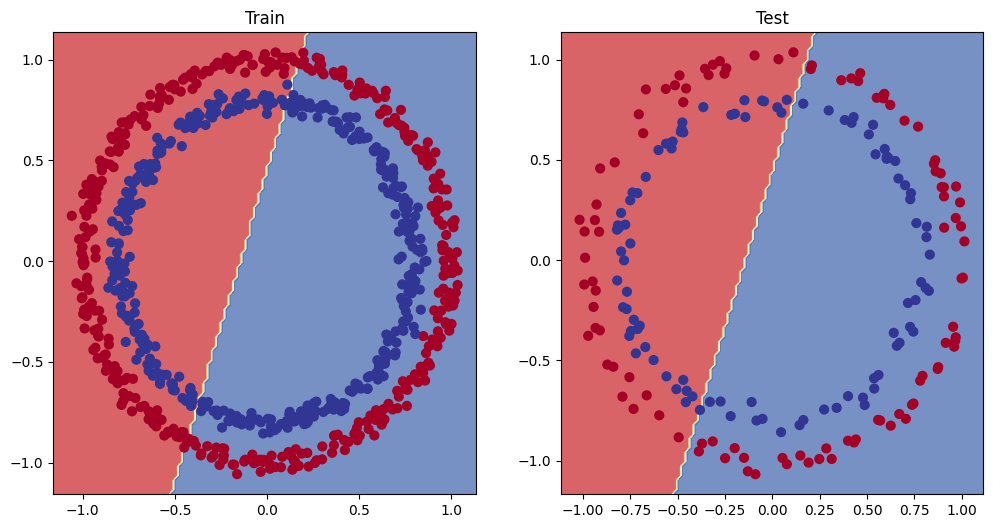

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#creating some linear data

In [25]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [26]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


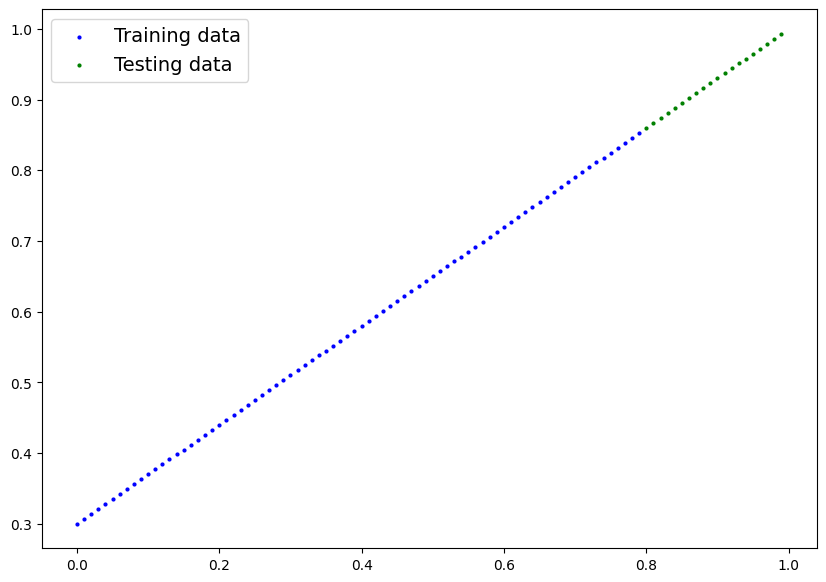

In [27]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [28]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [30]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.57896, Test loss: 0.47265
Epoch: 100 | Train loss: 0.05652, Test loss: 0.17491
Epoch: 200 | Train loss: 0.05272, Test loss: 0.15038
Epoch: 300 | Train loss: 0.05733, Test loss: 0.14733
Epoch: 400 | Train loss: 0.05780, Test loss: 0.14758
Epoch: 500 | Train loss: 0.04943, Test loss: 0.12419
Epoch: 600 | Train loss: 0.05284, Test loss: 0.14350
Epoch: 700 | Train loss: 0.07244, Test loss: 0.12574
Epoch: 800 | Train loss: 0.04493, Test loss: 0.11135
Epoch: 900 | Train loss: 0.05377, Test loss: 0.13252


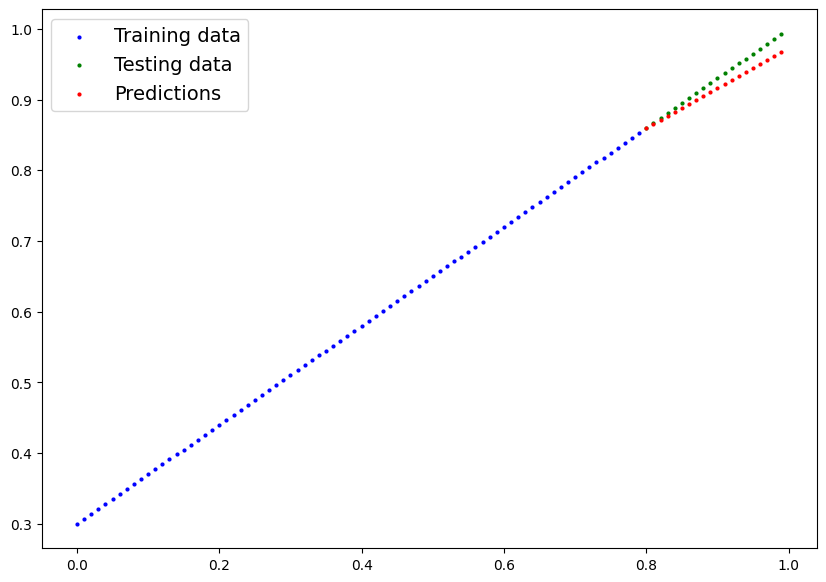

In [31]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

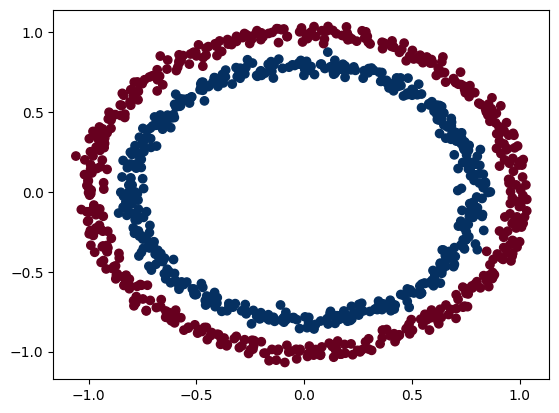

In [32]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [33]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#building a model with non Linear

In [34]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [35]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [36]:
# Fit the model
torch.manual_seed(42)
epochs = 20000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

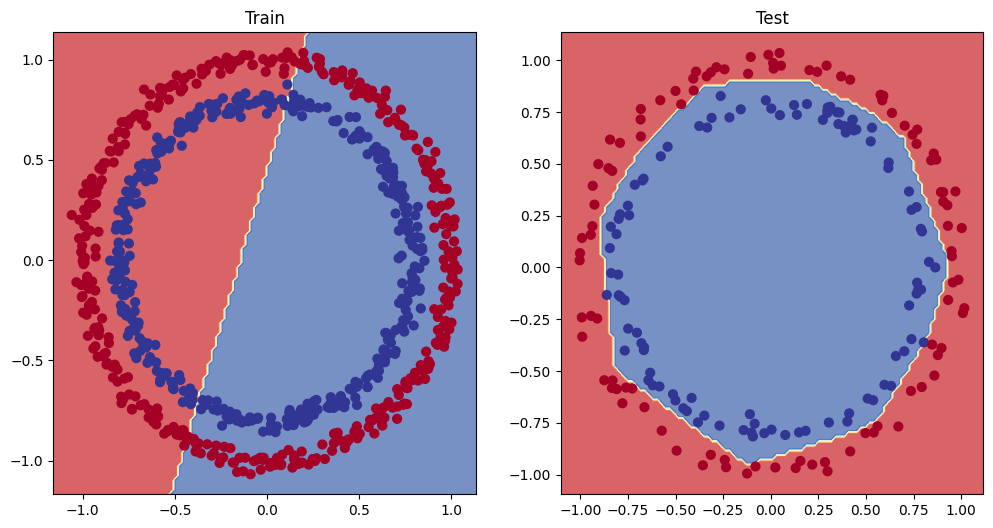

In [37]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


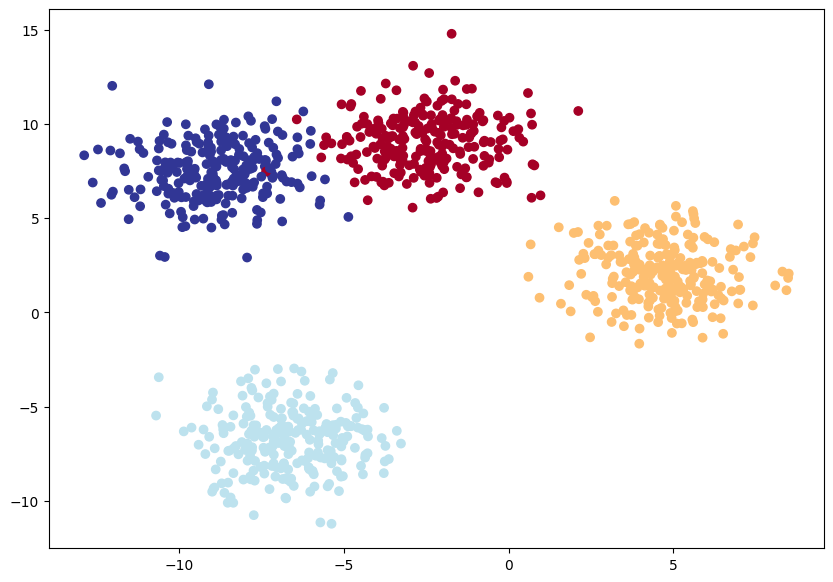

In [38]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

#BUilding a multi class classification

In [42]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [43]:
#loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),lr = 0.1)

In [44]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [47]:
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([  9.7278,  -8.5088, -14.0280, -11.2022,  11.0016,  -6.1079,  11.6334,
         13.0299, -12.8097, -22.6171], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [48]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
        [-0.9359, -2.0669,  0.9583, -2.2816],
        [-0.6742, -0.0694,  0.8067, -1.3123],
        [ 0.6858, -0.5307, -0.1840,  0.3610],
        [ 0.1430, -1.9414,  0.1816, -0.8017]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4563, 0.0833, 0.1518, 0.3087],
        [0.1215, 0.0392, 0.8077, 0.0316],
        [0.1289, 0.2361, 0.5669, 0.0681],
        [0.4102, 0.1215, 0.1719, 0.2964],
        [0.3918, 0.0487, 0.4072, 0.1523]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [49]:
#conver our models prediction prob to pred lables
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0], device='cuda:0')

In [53]:
#create a training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#set no of epochs
epochs = 300
#put data on target
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)
#looop
for epoch in range(epochs):
  model_4.train()
  #forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim = 1)
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim = 1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.02546, Acc: 99.12% | Test Loss: 0.01365, Test Acc: 23.00%
Epoch: 10 | Loss: 0.02543, Acc: 99.12% | Test Loss: 0.01362, Test Acc: 23.00%
Epoch: 20 | Loss: 0.02541, Acc: 99.12% | Test Loss: 0.01359, Test Acc: 23.00%
Epoch: 30 | Loss: 0.02538, Acc: 99.12% | Test Loss: 0.01356, Test Acc: 23.00%
Epoch: 40 | Loss: 0.02535, Acc: 99.12% | Test Loss: 0.01353, Test Acc: 23.00%
Epoch: 50 | Loss: 0.02533, Acc: 99.12% | Test Loss: 0.01350, Test Acc: 23.00%
Epoch: 60 | Loss: 0.02530, Acc: 99.12% | Test Loss: 0.01346, Test Acc: 23.00%
Epoch: 70 | Loss: 0.02527, Acc: 99.12% | Test Loss: 0.01343, Test Acc: 23.00%
Epoch: 80 | Loss: 0.02524, Acc: 99.12% | Test Loss: 0.01340, Test Acc: 23.00%
Epoch: 90 | Loss: 0.02522, Acc: 99.12% | Test Loss: 0.01337, Test Acc: 23.00%
Epoch: 100 | Loss: 0.02519, Acc: 99.25% | Test Loss: 0.01334, Test Acc: 23.00%
Epoch: 110 | Loss: 0.02517, Acc: 99.25% | Test Loss: 0.01332, Test Acc: 23.00%
Epoch: 120 | Loss: 0.02514, Acc: 99.25% | Test Loss: 0.01329, T

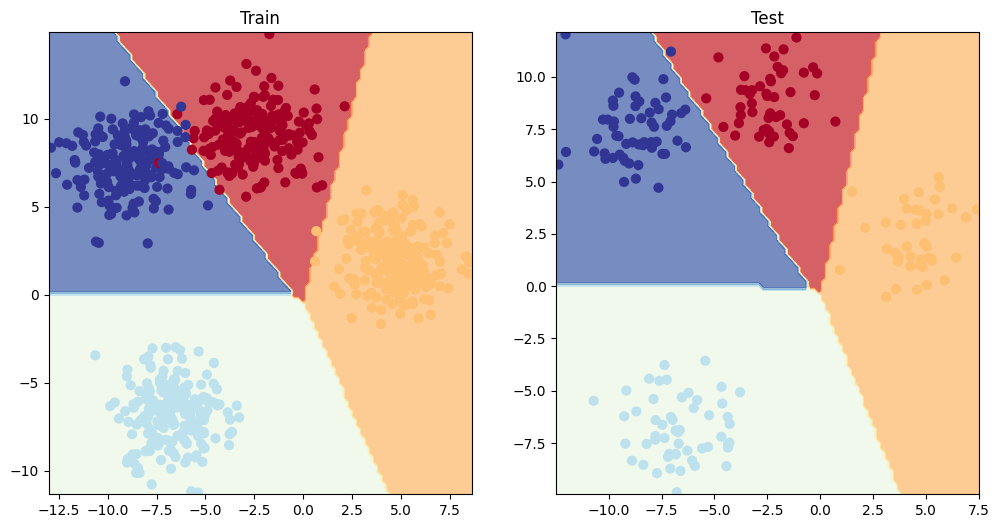

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

In [2]:
device

'cuda'

In [3]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
samples = 1000
X,y = make_moons(n_samples=samples,noise = 0.07,random_state=RANDOM_SEED)
X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [5]:
# Turn data into a DataFrame
import pandas as pd
data_df = pd.DataFrame({
    "X0":X[:,0],
    "X1":X[:,1],
    "y":y}
)

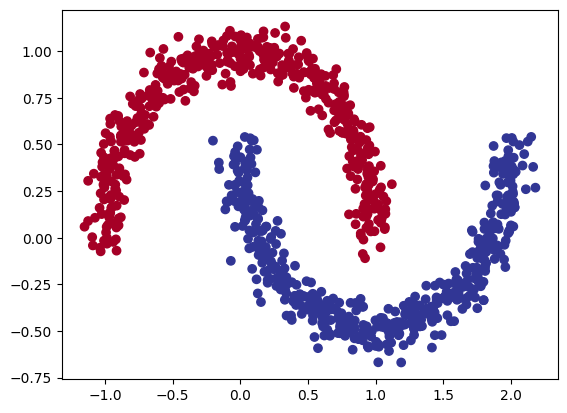

In [6]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [7]:
# Turn data into tensors of dtype float
X=torch.tensor(X,dtype = torch.float)
y=torch.tensor(y,dtype=torch.float)
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [36]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_5 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_5

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_5.parameters(),lr = 0.1)

In [38]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_5(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_5(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_5(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.0019, 0.0094, 0.0161, 0.0185, 0.0284, 0.0192, 0.0291, 0.0196, 0.0258,
        0.0079], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5005, 0.5024, 0.5040, 0.5046, 0.5071, 0.5048, 0.5073, 0.5049, 0.5065,
        0.5020], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [39]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn


MulticlassAccuracy()

In [40]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 20000

# Send data to the device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Loop through the data
for epoch in range(epochs):
  ### Training
  model_5.train()

  # 1. Forward pass
  y_logits = model_5(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model_5.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_5(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what's happening
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70 Acc: 0.37 | Test loss: 0.69 Test acc: 0.50
Epoch: 1000 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 2000 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 3000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 4000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 5000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 6000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 7000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 8000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 9000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 10000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 11000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 12000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 13000 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 14000 | Loss: 0.00 Acc: 1.00 | Test loss

In [41]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

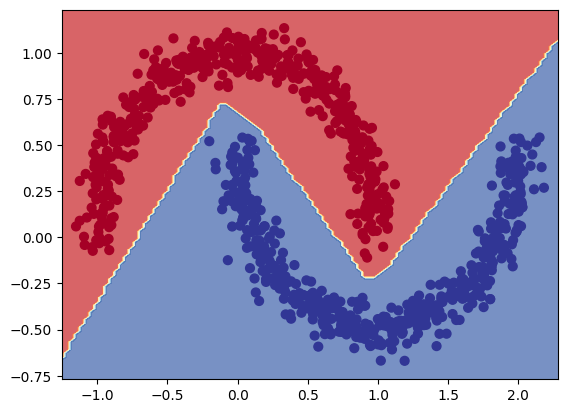

In [42]:
plot_decision_boundary(model = model_5,X = X,y=y)